In [1]:
#Import the neccassary libraries. 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from ipywidgets import widgets
from ipywidgets import interact

In [2]:
#Import the excel file.
pol_data = pd.ExcelFile('Project Pollinator Count Data Collection Sheet 2022.xlsx')

#Select the sheet of interest and create a dataframe based off the sheet. 
df_pol_sh1 = pd.read_excel(pol_data, 'Summer 2022 Pollinator Data Col')

df_pol_sh1.replace('total_shade', 'full_shade', inplace=True)

In [3]:
df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator']

In [4]:
#Cleaning Up the data and making a new column called "pollinator_group", that then is designated based 
# on one of the 9 codes (Honey Bee, Bumble Bee, Sweat Bee, Hover Fly, Wasp, Leafcutter Bee, Fly, or Butterfly)

df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator_group'].replace('HB', 'Honey Bee')
df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator_group'].replace('BVO', 'Bumble Bee')
df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator_group'].replace('HF', 'Hover Fly')
df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator_group'].replace('SB', 'Sweat Bee')
df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator_group'].replace('BFL', 'Bumble Bee')
df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator_group'].replace('BI', 'Bumble Bee')
df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator_group'].replace('BME', 'Bumble Bee')
df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator_group'].replace('BMI', 'Bumble Bee')
df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator_group'].replace('BS', 'Bumble Bee')
df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator_group'].replace('BVO', 'Bumble Bee')
df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator_group'].replace('BU', 'Bumble Bee')
df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator_group'].replace('BB', 'Bumble Bee')
df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator_group'].replace('BUT', 'Butterfly')
df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator_group'].replace('BMI', 'Bumble Bee')
df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator_group'].replace('LB', 'Leafcutter Bee')
df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator_group'].replace('MB', 'Leafcutter Bee')
df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator_group'].replace('W', 'Wasp')
df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator_group'].replace('BF', 'Fly')

#The OP's need additional sorting. 

df_pol_sh1.loc[(df_pol_sh1['pollinator'] == 'OP') & (df_pol_sh1['insect_order'] == 'diptera'), 'pollinator_group'] = 'Fly'
df_pol_sh1.loc[(df_pol_sh1['pollinator'] == 'OP') & (df_pol_sh1['insect_order'] == 'coleoptera'), 'pollinator_group'] = 'Beetle'

#Getting rid of any of the left over data points that can't be categorized into the above codes. 

index_names = df_pol_sh1[(df_pol_sh1['pollinator_group'] == 'NI') | (df_pol_sh1['pollinator_group'] == 'OP') | (df_pol_sh1['pollinator_group'] == 'UB')].index
df_pol_sh1.drop(index_names, inplace = True)


In [5]:
#Make a function that makes a dict of column names and their associated index from an inputed dataframe. 
def Dict_of_column_NameIndex(dataframe):
    
    column_names = []
    column_index = []

    for name in dataframe.columns: 
        column_names.append(name)
    
    for name in dataframe.columns:
        column_index.append(dataframe.columns.get_loc(name)) 
    
    dict_column_index = dict(zip(column_names, column_index))

    return dict_column_index

In [6]:
#Run the function to create a dict. 
dict_column_index = Dict_of_column_NameIndex(df_pol_sh1)

#Print the dict in an alligned format. 
for key, value in dict_column_index.items():
    print('{: >35} {: >3}'.format(key, value))

                        sample_date   0
                     collector_name   1
                           location   2
                    location_number   3
                  time_code (M,A,E)   4
                       sample_start   5
                         sample_end   6
                            weather   7
                       wind (km/hr)   8
                       air_temp(C°)   9
                     shade_coverage  10
                     observation_id  11
                         pollinator  12
                       insect_order  13
                      insect_family  14
                       insect_genus  15
                     insect_species  16
                         plant_host  17
                        plant_order  18
                       plant_family  19
                        plant_genus  20
                      plant_species  21
                        plant_color  22
                      plant_pattern  23
                  Photo reference #  24


Figure 1: This figure takes the percentage difference of both the average number of visitations of pollinators and the mean temperature for each 7 day period from June 12 to Sept 11th. 

Mean visitionsation: Calucalted for each week by taking the total number of visitation for that week and dividing it 
by the total number of survey locations that were sampled in that week and does that for each week. 

Mean Temperature: Calulated by adding all the temperatures for a week together and then dividing it by the number of visitations. 

In [7]:
# A function that intakes a df column and returns a list of the percent differences with the first value being 
#the baseline percentage of 100.

def turn_into_percent_difference(old_series):
    initial_value = old_series[0]
    new_list = []
    for index in old_series:
        new_list.append((index/ initial_value)*100)
    return new_list

In [8]:
def average_per_week(Request):

	#Creating bins, each bin will be a week starting on May 16, 2022, and going for 18 weeks. 
	bins = pd.date_range(start='2022-05-15', freq='1W', periods=18)

	#Creating A column with the binned categorization. 
	df_pol_sh1['binned_week'] = pd.cut(df_pol_sh1['sample_date'], bins = bins)

	# #find the total number of pollinators according to location number and time code
	if(Request == 'Average'):
		series_mean = df_pol_sh1['binned_week'].value_counts() / df_pol_sh1.groupby('binned_week')['location_number'].nunique()
	else:
		df_pol_sh1_request = df_pol_sh1[(df_pol_sh1['pollinator_group'] == Request)]
		series_mean = df_pol_sh1_request ['binned_week'].value_counts() / df_pol_sh1_request .groupby('binned_week')['location_number'].nunique()

	#Gets the mean temperature per week and turns it into a series. 
	series_mean_temp = df_pol_sh1.groupby('binned_week')['air_temp(C°)'].mean()

	df_mean = pd.DataFrame(series_mean)
	df_mean_temp = pd.DataFrame(series_mean_temp)
	df_mean.fillna(1, inplace=True)

	# Conveting the series into dataframes and while not including the first 4 weeks. 

	df_mean['Abundance_percentage'] = turn_into_percent_difference(df_mean[0])
	df_mean['Temp_percentage'] = turn_into_percent_difference(df_mean_temp['air_temp(C°)'])

	#Dropping the original mean column. 

	df_mean = df_mean.drop(0, axis=1)

	#Adding a new index column that is a single data format instead of a data range and 
	# converting it to a string of Mon, day, year format. 

	df_mean['date'] = bins[1:]
	df_mean.set_index(["date"],inplace=True)
	df_mean.index = df_mean.index.strftime("%b %d, %Y")

	#Plotting both percentage difference of visitations and temperature of weeks. 

	fig, ax = plt.subplots()
	ax.plot(df_mean.index, df_mean['Abundance_percentage'], linewidth=3, color='#63B7B7')
	ax.plot(df_mean.index, df_mean['Temp_percentage'], linewidth=3, color='#FF6961')
	plt.xticks(rotation = 60, horizontalalignment='right')
	ax.legend(['Visitations', 'Temperature'])
	ax.set_ylabel('Percent Difference (%)')
	ax.set_xlabel('Week')
	ax.set_title('Percent Difference of Average Visition Number and \n Temperature For Each Week Between June 12 and September 11th.',
				fontname = 'Georgia', 
				fontsize= 16, 
				pad=30)
	ax.grid()

	plt.show()

Figure 2: This figure takes the abundances of each of the different shade types (Full Shade, Mostly Shade, Mostly Sun, Full Sun), and gives the abundaces for each for the three gardens. 

In addtion two versions of this figure were created. 
- One for all visitations when the temperature was greater than or equal to 24 degrees celsius. 
- The other for all visitations when the temperature was less than 24 degrees celsius 

In [47]:
#Grouping the visitations based on temperature and then making new smaller df's with only the shade coverage and location information. 

df_shade_pol_abundance_less24= df_pol_sh1[df_pol_sh1['air_temp(C°)'] < 24]
df_shade_pol_abundance_greatEqual24= df_pol_sh1[df_pol_sh1['air_temp(C°)'] >= 24]

df_shade_pol_counts = pd.DataFrame()
df_shade_pol_counts['less24'] = pd.DataFrame(df_shade_pol_abundance_less24['location'].value_counts())
df_shade_pol_counts['greatEqual24'] = pd.DataFrame(df_shade_pol_abundance_greatEqual24['location'].value_counts())
df_shade_pol_counts['Difference'] = df_shade_pol_counts['less24'] - df_shade_pol_counts['greatEqual24']

df_shade_pol_abundance_less24 = pd.DataFrame(df_shade_pol_abundance_less24.groupby('location')[['shade_coverage', 'location']].value_counts())
df_shade_pol_abundance_greatEqual24 = pd.DataFrame(df_shade_pol_abundance_greatEqual24.groupby('location')[['shade_coverage', 'location']].value_counts())

df_shade_pol_abundance_greatEqual24 = df_shade_pol_abundance_greatEqual24.unstack().fillna(0)
df_shade_pol_abundance_less24 = df_shade_pol_abundance_less24.unstack().fillna(0)


In [49]:
df_shade_pol_counts

,less24,greatEqual24,Difference
Student_Union,568,180,388
Community_Garden,493,270,223
Library,310,82,228


[Text(0, 0, '388'), Text(0, 0, '223'), Text(0, 0, '228')]

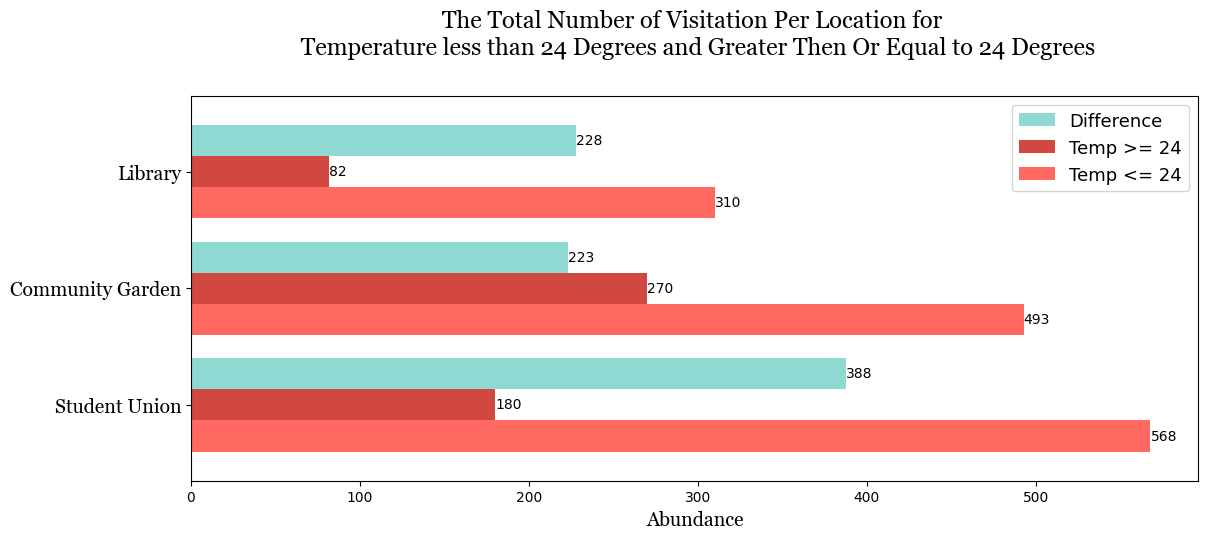

In [65]:
fig, ax =plt.subplots(figsize=(13, 5))
df_shade_pol_counts.plot(kind='barh', ax=ax, color = ['#FF6961', '#D14841', '#8ED9D1'], width=.8)
ax.set_title('The Total Number of Visitation Per Location for \n Temperature less than 24 Degrees and Greater Then Or Equal to 24 Degrees',
                fontname = 'Georgia', 
				fontsize= 17, 
                pad=30)

handles, labels = ax.get_legend_handles_labels()
new_labels = ['Temp <= 24', 'Temp >= 24', 'Difference']
ax.legend(reversed(handles), reversed(new_labels), loc='upper right', prop = {'size' : 13})
ax.set_xlabel('Abundance', 
                fontname = 'Georgia', 
                fontsize= 14)
ax.set_yticklabels(['Student Union', 'Community Garden', 'Library'], 
                    fontname = 'Georgia', 
                    fontsize= 14)
bars = ax.containers
ax.bar_label(bars[0], label_type='edge')
ax.bar_label(bars[1], label_type='edge')
ax.bar_label(bars[2], label_type='edge')

AttributeError: 'Axes' object has no attribute 'fig'

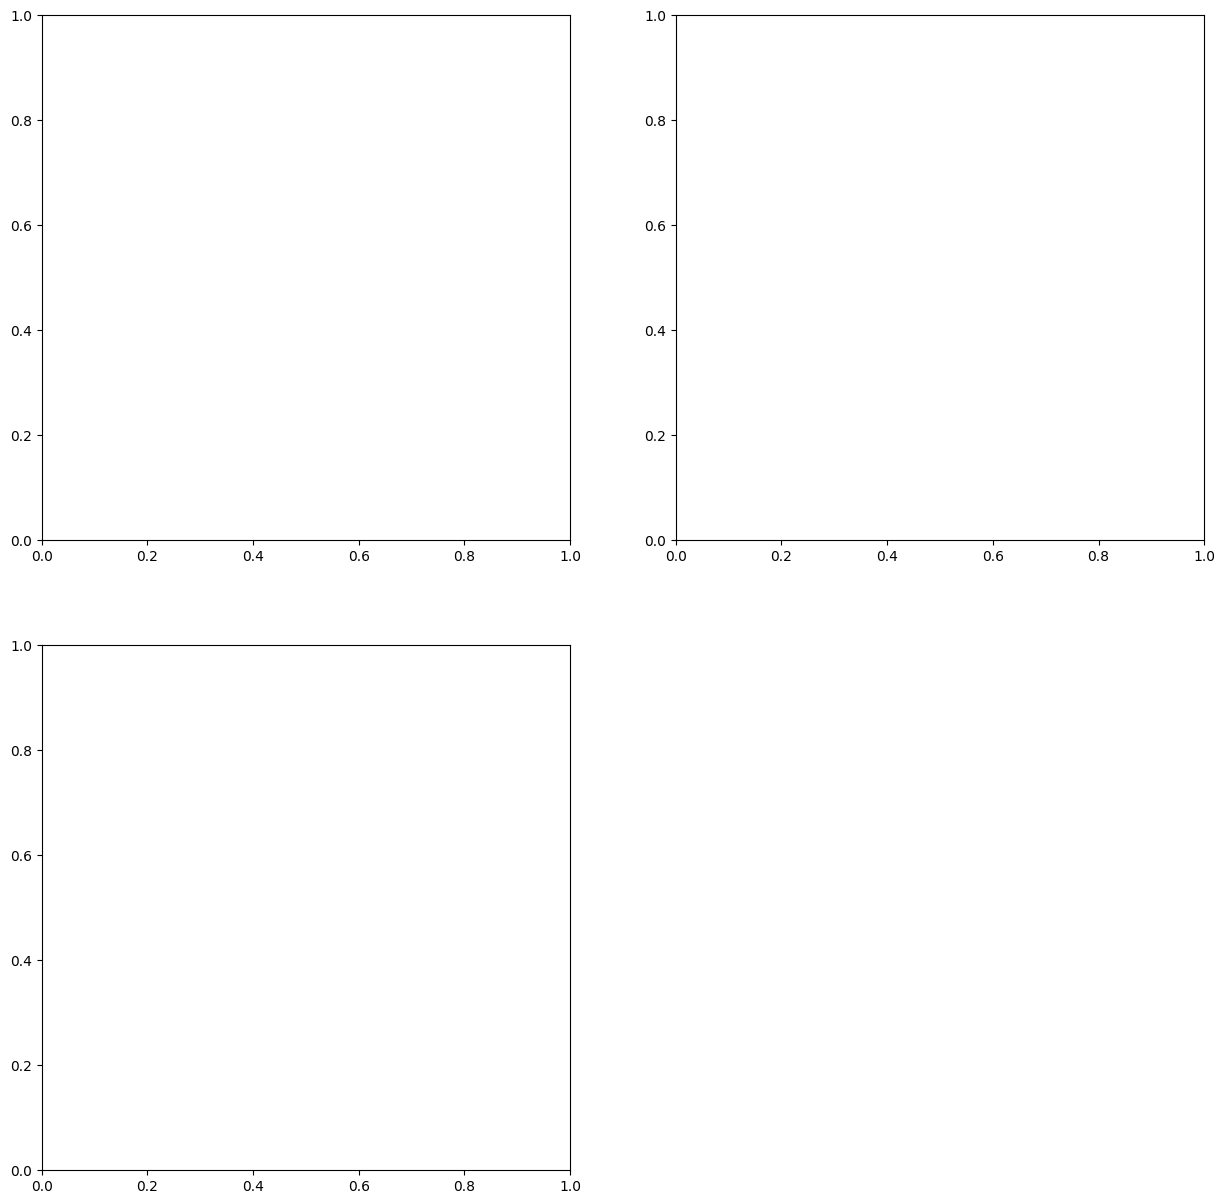

In [100]:
fig, ax =plt.subplots(2, 2, figsize = [15, 15])
ax[1, 1].remove()
df_shade_pol_abundance_greatEqual24.plot(kind='bar', ax=ax[0][0], color = ['#63B7B7', '#8ED9D1', '#D14841', '#FF6961'], width=.8)
df_shade_pol_abundance_less24.plot(kind='bar', ax=ax[0][1], color = ['#63B7B7', '#8ED9D1', '#D14841', '#FF6961'], width=.8)
df_shade_pol_counts.plot(kind='barh', ax=ax[1][0], color = ['#FF6961', '#D14841', '#8ED9D1'], width=.8)

ax[0][0].set_title('Counts For Shade Type When the \n Temperature Was ' + r"$\bf{" + "Greater " + "}$" + ' Than \n 24 Degrees',
                fontname = 'Georgia', 
				fontsize= 17, 
                pad=20)
ax[0][1].set_title('Counts For Shade Type When the \n Temperature Was ' + r"$\bf{" + "Less " + "}$" + ' Than \n 24 Degrees', 
                fontname = 'Georgia', 
				fontsize= 17, 
				pad=20)

for axes in ax[0]:
    axes.legend(['Full Shade', 'Mostly Shade', 'Full Sun', "Mostly Sun"], loc='upper center')
    axes.set_xlabel('')
    axes.set_xticklabels(['Community Garden', 'Library', 'Student Union'], rotation=60, horizontalalignment='right', fontsize=10)
    axes.set_ylabel('Abundance', 
                    fontname = 'Georgia', 
                    fontsize= 14)
    for p in axes.containers:
        for bar in p:
            axes.text(bar.get_x() + bar.get_width() / 2., bar.get_height(), '%d' % int(bar.get_height()), 
                    fontsize=8, color='black', ha='center', va='bottom')
            
ax[1][0].set_title('The Total Number of Visitation Per Location for \n Temperature less than 24 Degrees and Greater Then Or Equal to 24 Degrees',
                fontname = 'Georgia', 
				fontsize= 17, 
                pad=30)

handles, labels = ax[1][0].get_legend_handles_labels()
new_labels = ['Temp <= 24', 'Temp >= 24', 'Difference']
ax[1][0].legend(reversed(handles), reversed(new_labels), loc='upper right', prop = {'size' : 13})
ax[1][0].set_xlabel('Abundance', 
                fontname = 'Georgia', 
                fontsize= 14)
ax[1][0].set_yticklabels(['Student Union', 'Community Garden', 'Library'], 
                    fontname = 'Georgia', 
                    fontsize= 14)
bars = ax[1][0].containers
ax[1][0].bar_label(bars[0], label_type='edge')
ax[1][0].bar_label(bars[1], label_type='edge')
ax[1][0].bar_label(bars[2], label_type='edge') 


IndexError: index 2 is out of bounds for axis 0 with size 2

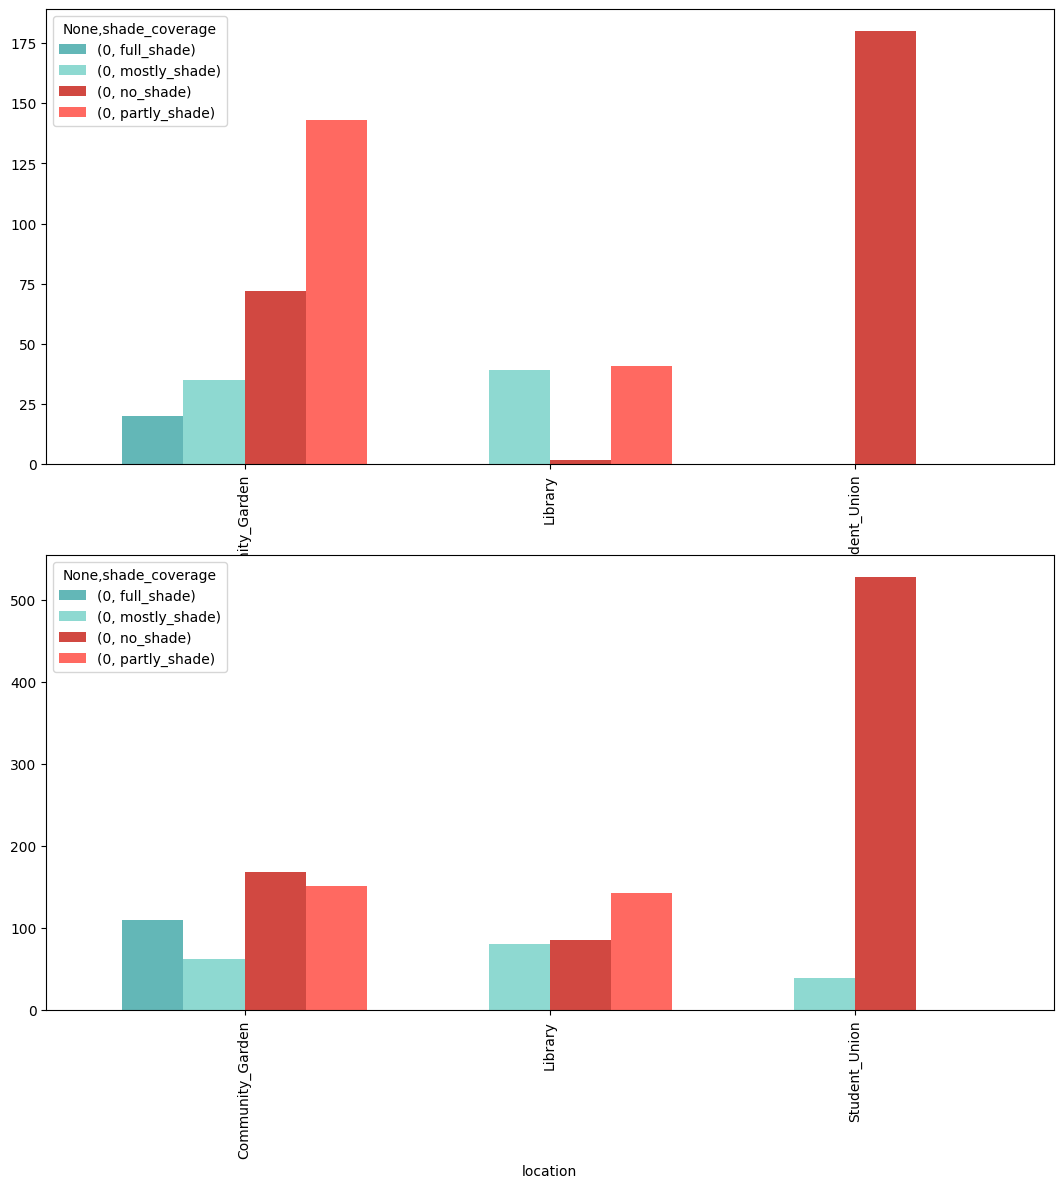

In [73]:
fig, ax =plt.subplots(2, 2, figsize=(13, 13))
df_shade_pol_abundance_greatEqual24.plot(kind='bar', ax=ax[0], color = ['#63B7B7', '#8ED9D1', '#D14841', '#FF6961'], width=.8)
df_shade_pol_abundance_less24.plot(kind='bar', ax=ax[1], color = ['#63B7B7', '#8ED9D1', '#D14841', '#FF6961'], width=.8)
df_shade_pol_counts.plot(kind='barh', ax=ax[2], color = ['#FF6961', '#D14841', '#8ED9D1'], width=.8)

In [ ]:
ax[0].set_title('Counts For Shade Type When the \n Temperature Was ' + r"$\bf{" + "Greater " + "}$" + ' Than \n 24 Degrees',
                fontname = 'Georgia', 
				fontsize= 17, 
                pad=20)
ax[1].set_title('Counts For Shade Type When the \n Temperature Was ' + r"$\bf{" + "Less " + "}$" + ' Than \n 24 Degrees', 
                fontname = 'Georgia', 
				fontsize= 17, 
				pad=20)

for axes in ax[:2]:
    axes.legend(['Full Shade', 'Mostly Shade', 'Full Sun', "Mostly Sun"], loc='upper center')
    axes.set_xlabel('')
    axes.set_xticklabels(['Community Garden', 'Library', 'Student Union'], rotation=60, horizontalalignment='right', fontsize=10)
    axes.set_ylabel('Abundance', 
                    fontname = 'Georgia', 
                    fontsize= 14)
    for p in axes.containers:
        for bar in p:
            axes.text(bar.get_x() + bar.get_width() / 2., bar.get_height(), '%d' % int(bar.get_height()), 
                    fontsize=8, color='black', ha='center', va='bottom')
            
ax[3].set_title('The Total Number of Visitation Per Location for \n Temperature less than 24 Degrees and Greater Then Or Equal to 24 Degrees',
                fontname = 'Georgia', 
				fontsize= 17, 
                pad=30)

handles, labels = ax[3].get_legend_handles_labels()
new_labels = ['Temp <= 24', 'Temp >= 24', 'Difference']
ax[3].legend(reversed(handles), reversed(new_labels), loc='upper right', prop = {'size' : 13})
ax[3].set_xlabel('Abundance', 
                fontname = 'Georgia', 
                fontsize= 14)
ax[3].set_yticklabels(['Student Union', 'Community Garden', 'Library'], 
                    fontname = 'Georgia', 
                    fontsize= 14)
bars = ax.containers
ax[3].bar_label(bars[0], label_type='edge')
ax[3].bar_label(bars[1], label_type='edge')
ax[3].bar_label(bars[2], label_type='edge')

In [15]:
widgets.interact(average_per_week, Request = df_pol_sh1['pollinator_group'].unique())

interactive(children=(Dropdown(description='Request', options=('Bumble Bee', 'Fly', 'Butterfly', 'Honey Bee', …

<function __main__.average_per_week(Request)>

In [ ]:
def update(change):
    line.set_ydata(np.sin(change.new * x))
    fig.canvas.draw()
     
int_slider = widgets.IntSlider(
    value=1, 
    min=0, max=10, step=1,
    description='$\omega$',
    continuous_update=False
)
int_slider.observe(update, 'value')
int_slider